## 1. Nauka klasyfikatora - kostki

Dokumentacja: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [1]:
from generating_data import generate_checkerboard, generate_data

In [2]:
x, y = generate_checkerboard(n_size=3, n_samples=1000)

In [69]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import timeit
import time
import pandas as pd

experiment_data = []

n_dimensions_experiments = [2, 3, 10]
n_samples_experiments = [200, 400, 1000, 2000, 4000]

for n_dimensions in n_dimensions_experiments:
    for n_samples in n_samples_experiments:
        X, y, _ = generate_data(n_dimension=n_dimensions, n_samples=n_samples, noise=False)

        # test, train split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

        # parameters
        algorithms = ['ball_tree', 'kd_tree', 'brute']
        leaf_sizes = [2, 30, 100]
        n_neighbors = [3, 7, 9, 27, 65, 99]

        # fitting algorithms and caculating score
        for a in algorithms:
            for l in leaf_sizes:
                for n in n_neighbors:
                    knn = KNeighborsClassifier(n_neighbors=n, leaf_size=l, algorithm=a)
                    time_fit_start = time.time()
                    knn.fit(X_train, y_train)
                    time_fit_end = time.time()
                    time_fit = time_fit_end - time_fit_start

                    time_predict_start = time.time()
                    score = knn.score(X_test, y_test)
                    time_predict_end = time.time()
                    time_predict = time_predict_end - time_fit_start
                    experiment_data.append([n_dimensions, n_samples, n, l, a, score, time_predict, time_predict])
            
df = pd.DataFrame(experiment_data, columns = ['n_dimensions', 'n_samples', 'n_neigbors', 'leaf_size', 'algorithm', 'score', 'time_fit', 'time_predict'])
df = df.set_index(['n_dimensions','n_samples'])
df

n_neigbors  leaf_size  algorithm   score  time_fit  \
n_dimensions n_samples                                                       
2            200                 3          2  ball_tree  0.9700  0.008998   
             200                 7          2  ball_tree  0.9800  0.007001   
             200                 9          2  ball_tree  0.9800  0.009001   
             200                27          2  ball_tree  0.9900  0.008002   
             200                65          2  ball_tree  0.9700  0.009997   
...                            ...        ...        ...     ...       ...   
10           4000                7        100      brute  0.8875  0.208000   
             4000                9        100      brute  0.8950  0.217999   
             4000               27        100      brute  0.9085  0.212007   
             4000               65        100      brute  0.9280  0.230996   
             4000               99        100      brute  0.9335  0.242999   

                        time_predict  
n_dimensions n_samples                
2            200            0.008998  
             200            0.007001  
             200            0.009001  
             200            0.008002  
             200            0.009997  
...                              ...  
10           4000           0.208000  
             4000           0.217999  
             4000           0.212007  
             4000           0.230996  
             4000           0.242999  

[810 rows x 6 columns]

In [70]:
df.to_csv('experiment_data.csv')

In [30]:
from generating_data import generate_checkerboard
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import timeit
import time
import pandas as pd

experiment_data = []

n_dimensions_experiments = [2, 7, 19]
n_samples_experiments = [200, 400, 1000, 2000, 4000]

for n_dimensions in n_dimensions_experiments:
    for n_samples in n_samples_experiments:
        X, y = generate_checkerboard(n_size=n_dimensions, n_samples=n_samples)

        # test, train split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

        # parameters
        algorithms = ['ball_tree', 'kd_tree', 'brute']
        leaf_sizes = [2, 30, 100]
        n_neighbors = [3, 7, 9, 27, 65, 99]

        # fitting algorithms and caculating score
        for a in algorithms:
            for l in leaf_sizes:
                for n in n_neighbors:
                    knn = KNeighborsClassifier(n_neighbors=n, leaf_size=l, algorithm=a)
                    time_fit_start = time.time()
                    knn.fit(X_train, y_train)
                    time_fit_end = time.time()
                    time_fit = time_fit_end - time_fit_start

                    time_predict_start = time.time()
                    score = knn.score(X_test, y_test)
                    time_predict_end = time.time()
                    time_predict = time_predict_end - time_fit_start
                    experiment_data.append([n_dimensions, n_samples, n, l, a, score, time_predict, time_predict])
            
df = pd.DataFrame(experiment_data, columns = ['n_dimensions', 'n_samples', 'n_neigbors', 'leaf_size', 'algorithm', 'score', 'time_fit', 'time_predict'])
df = df.set_index(['n_dimensions','n_samples'])
df.to_csv('checkerboard_data.csv')

## 2. Interpretacja zebranych danych - kostki

In [3]:
import pandas as pd
df = pd.read_csv('experiment_data.csv')
# df = df.set_index(['n_dimensions','n_samples'])
df['time'] = df['time_fit'] + df['time_predict']

### 2.1 Dla każdego zbioru wyznaczyć optymalna wartość parametru $k$

In [4]:
best_k = df.loc[(df['leaf_size'] == 30) & (df['algorithm'] == 'brute')]
best_k.sort_values('score', ascending=False).drop_duplicates(subset=['n_dimensions', 'n_samples'])

,n_dimensions,n_samples,n_neigbors,leaf_size,algorithm,score,time_fit,time_predict,time
261,2,4000,27,30,brute,0.9920,0.219002,0.219002,0.438004
206,2,2000,9,30,brute,0.9920,0.074001,0.074001,0.148001
45,2,200,27,30,brute,0.9900,0.006994,0.006994,0.013989
152,2,1000,9,30,brute,0.9880,0.033000,0.033000,0.066000
532,3,4000,65,30,brute,0.9825,0.219993,0.219993,0.439987
99,2,400,27,30,brute,0.9750,0.012997,0.012997,0.025994
477,3,2000,27,30,brute,0.9740,0.088004,0.088004,0.176007
368,3,400,9,30,brute,0.9700,0.012000,0.012000,0.024000
424,3,1000,65,30,brute,0.9620,0.037003,0.037003,0.074006
749,10,2000,99,30,brute,0.9380,0.088000,0.088000,0.176001


## 2. Intepretacja zebranych danych - szachownica

In [5]:
import pandas as pd
df = pd.read_csv('checkerboard_data.csv')
df['time'] = df['time_fit'] + df['time_predict']

best_k = df.loc[(df['leaf_size'] == 30) & (df['algorithm'] == 'brute')]
best_k.sort_values('score', ascending=False).drop_duplicates(subset=['n_dimensions', 'n_samples'])

,n_dimensions,n_samples,n_neigbors,leaf_size,algorithm,score,time_fit,time_predict,time
207,2,2000,27,30,brute,0.9870,0.077625,0.077625,0.155251
261,2,4000,27,30,brute,0.9825,0.186645,0.186645,0.373290
150,2,1000,3,30,brute,0.9720,0.030281,0.030281,0.060562
96,2,400,3,30,brute,0.9600,0.009851,0.009851,0.019702
43,2,200,7,30,brute,0.9400,0.005391,0.005391,0.010782
528,7,4000,3,30,brute,0.9330,0.234751,0.234751,0.469501
474,7,2000,3,30,brute,0.8990,0.083615,0.083615,0.167230
420,7,1000,3,30,brute,0.8460,0.026013,0.026013,0.052026
798,19,4000,3,30,brute,0.7500,0.207966,0.207966,0.415932
366,7,400,3,30,brute,0.7400,0.009997,0.009997,0.019994


## 3. Granica separacji

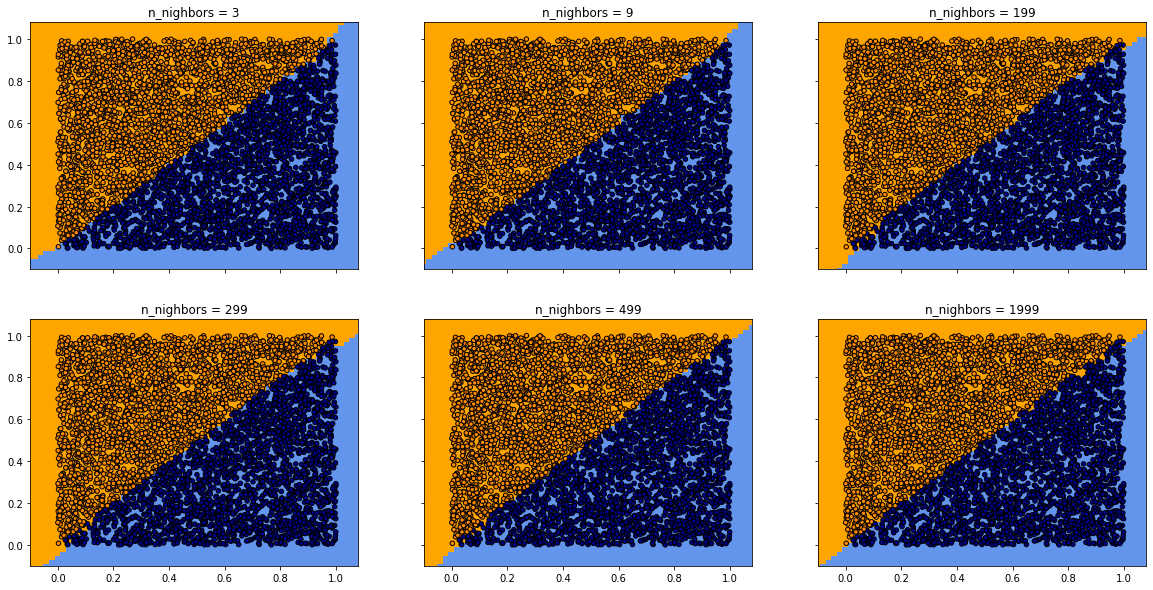

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.neighbors import KNeighborsClassifier


X, y, _ = generate_data(n_dimension=2, n_samples=5000, noise=False)

# parameters
n_neighbors = [3, 9, 199, 299, 499, 1999]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20, 10))

for idx, n in enumerate(n_neighbors):
    # fitting algorithms and caculating score
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X, y)

    # Create color maps
    cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    # generate points in whole domain
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    ax = axs.flat[idx]
    
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y,
                edgecolor='k', s=20, cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f"n_nighbors = {n}")


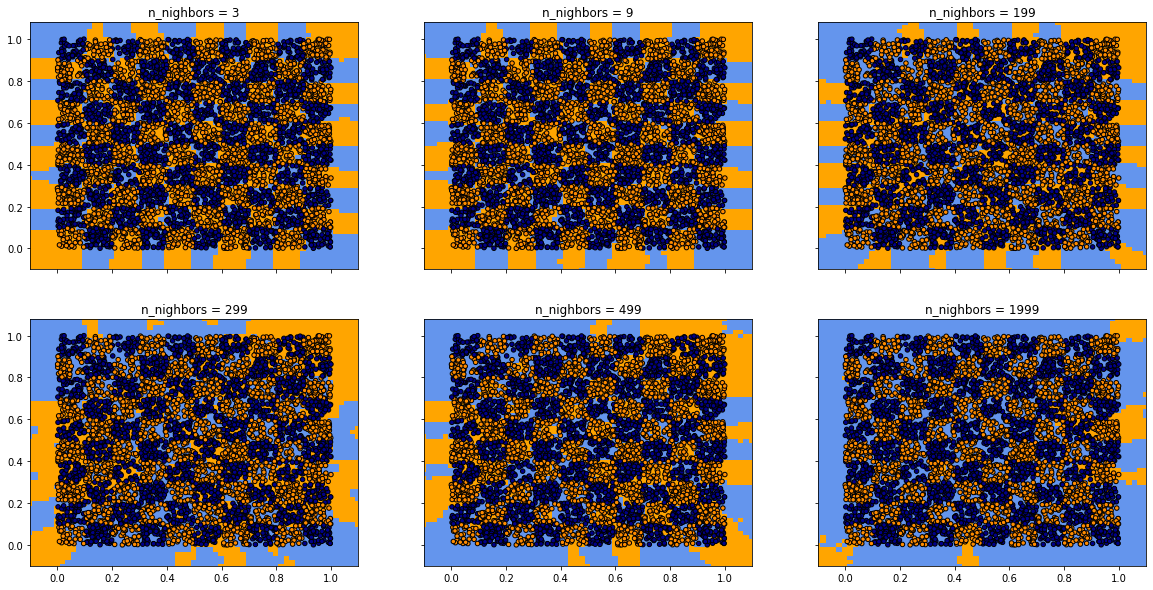

In [8]:
X, y = generate_checkerboard(n_size=10, n_samples=5000)

# parameters
n_neighbors = [3, 9, 199, 299, 499, 1999]

fig, axs = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(20, 10))

for idx, n in enumerate(n_neighbors):
    # fitting algorithms and caculating score
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X, y)

    # # Create color maps
    # cmap_light = ListedColormap(['orange', 'cyan', 'cornflowerblue'])
    # cmap_bold = ListedColormap(['darkorange', 'c', 'darkblue'])

    # generate points in whole domain
    h = .02  # step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    
    ax = axs.flat[idx]
    
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light, shading='auto')

    # Plot also the training points
    ax.scatter(X[:, 0], X[:, 1], c=y,
                edgecolor='k', s=20, cmap=cmap_bold)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_title(f"n_nighbors = {n}")

## 4. Złożoność obliczeniowa


In [9]:
import pandas as pd
df = pd.read_csv('experiment_data.csv')
df['time'] = df['time_fit'] + df['time_predict']
df

,n_dimensions,n_samples,n_neigbors,leaf_size,algorithm,score,time_fit,time_predict,time
0,2,200,3,2,ball_tree,0.9700,0.008998,0.008998,0.017997
1,2,200,7,2,ball_tree,0.9800,0.007001,0.007001,0.014002
2,2,200,9,2,ball_tree,0.9800,0.009001,0.009001,0.018003
3,2,200,27,2,ball_tree,0.9900,0.008002,0.008002,0.016005
4,2,200,65,2,ball_tree,0.9700,0.009997,0.009997,0.019995
...,...,...,...,...,...,...,...,...,...
805,10,4000,7,100,brute,0.8875,0.208000,0.208000,0.416001
806,10,4000,9,100,brute,0.8950,0.217999,0.217999,0.435999
807,10,4000,27,100,brute,0.9085,0.212007,0.212007,0.424015
808,10,4000,65,100,brute,0.9280,0.230996,0.230996,0.461992


Text(0, 0.5, 'time')

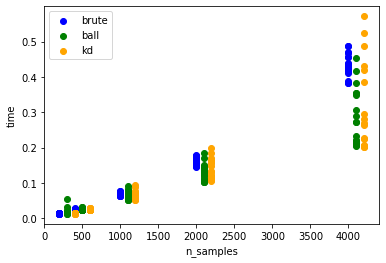

In [10]:
import matplotlib.pyplot as plt
brute = df.loc[(df['leaf_size'] == 30) & (df['algorithm'] == 'brute')]
ball = df.loc[(df['leaf_size'] == 30) & (df['algorithm'] == 'ball_tree')]
kd = df.loc[(df['leaf_size'] == 30) & (df['algorithm'] == 'kd_tree')]

plt.scatter(brute['n_samples'], brute['time'], color='blue', label='brute')
plt.scatter(ball['n_samples']+100, ball['time'], color='green', label='ball')
plt.scatter(kd['n_samples']+200, kd['time'], color='orange', label='kd')
plt.legend()
plt.xlabel('n_samples')
plt.ylabel('time')